```
From: https://github.com/ksatola
Version: 0.1.0
```

# Model - PM2.5 - Time Series Forecasting Diagnostics

## Contents

- [Preparing times series data for statistical forecasting](#base)
- Hourly forecast
    - [Load hourly data](#data_h)
    - [Diagnostics](#diag_h)
    - [Modelling](#model_h)
- Daily forecast
    - [Load daily data](#data_d)
    - [Diagnostics](#diag_d)
    - [Modelling](#model_d)

In [26]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%autoreload 2

In [3]:
import sys
sys.path.insert(0, '../src')

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd 
import numpy as np

from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.tsa.arima_model import ARMA

import matplotlib.pyplot as plt
%matplotlib inline

In [105]:
from model import (
    get_pm25_data_for_modelling,
    get_best_arima_params_for_time_series,
    get_df_for_lags_columns
)

from measure import (
    get_model_power
)

from plot import (
    #plot_train_test_predicted,
    plot_observed_vs_predicted,
    plot_observations_to_predictions_relationship,
    #fit_theoretical_dist_and_plot,
    plot_ts_corr
)

from stats import (
    adfuller_test
)

[autoreload of model failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 434, in superreload
    module = reload(module)
  File "/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "../src/model/__init__.py", line 7, in <module>
    from .common import (
ImportError: cannot import

ImportError: cannot import name 'get_df_for_lags_columns' from 'model' (../src/model/__init__.py)

---
<a id='base'></a>

## Preparing times series data for statistical forecasting

You need to be aware of the assumptions that are made prior to beginning working with data and statistical modelling in forecasting. The main assuptions are:

- The previous time step(s) - lag(s) - is useful in predicting the value at the next time step (dependance between values). If your time series data values are independent of each other, autoregression isn’t going to be a good forecasting method for that series (`correlation`).
- Your data is stationary. A time series is stationary if is mean (and/or variance) is constant over time (over a specified time range). If your time series data isn’t stationary, you’ll need to make it that way with some form of trend and seasonality removal (`decomposition`).

The first is looking at the plot of entire dataset.
Then checking the correlation between time series and its lags (autocorrelation)




As we can see, the previous time step(s) can be used in predicting the value at the next time step. Our data is also stationary, thus checking statistical models makes sense.

---
<a id='data_h'></a>

## Load hourly data

In [10]:
dfh = get_pm25_data_for_modelling('ts', 'h')
dfh.head()

common.py | 42 | get_pm25_data_for_modelling | 07-Jun-20 10:24:10 | INFO: Dataframe loaded: /Users/ksatola/Documents/git/air-polution/agh/data/dfpm25_2008-2018_hourly.hdf
common.py | 43 | get_pm25_data_for_modelling | 07-Jun-20 10:24:10 | INFO: Dataframe size: (96388, 1)


,pm25
Datetime,
2008-01-01 01:00:00,92.0
2008-01-01 02:00:00,81.0
2008-01-01 03:00:00,73.0
2008-01-01 04:00:00,60.5
2008-01-01 05:00:00,61.0


In [12]:
df = dfh.copy()

---
<a id='diag_h'></a>

## Diagnostics

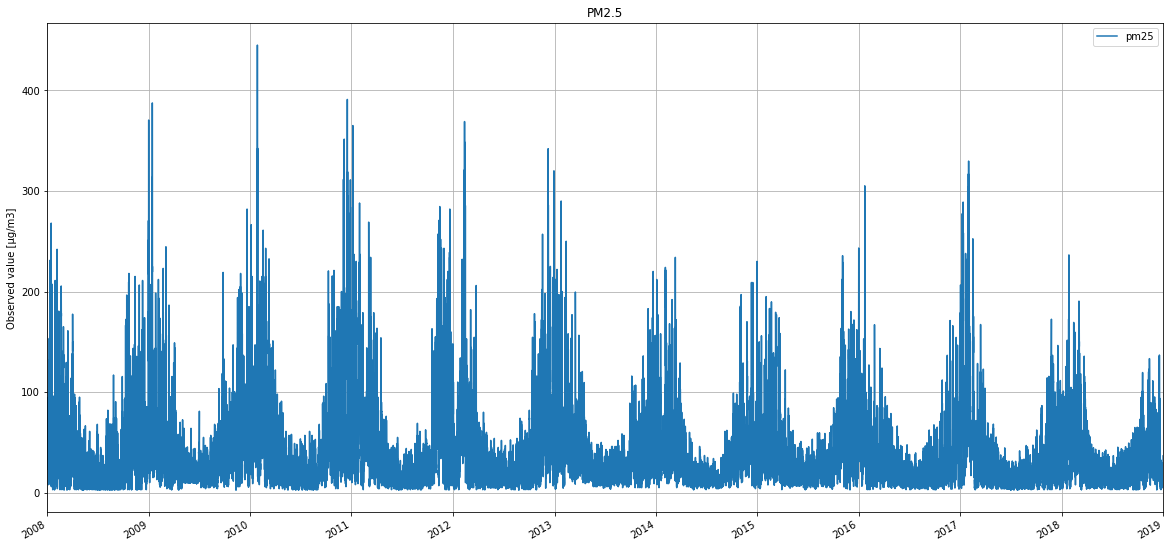

In [28]:
# Entire dataset plot
ax = df.plot(grid=True, figsize=(20, 10), alpha=1)
plt.title('PM2.5')
plt.ylabel('Observed value [µg/m3]')
plt.xlabel('')
plt.show();

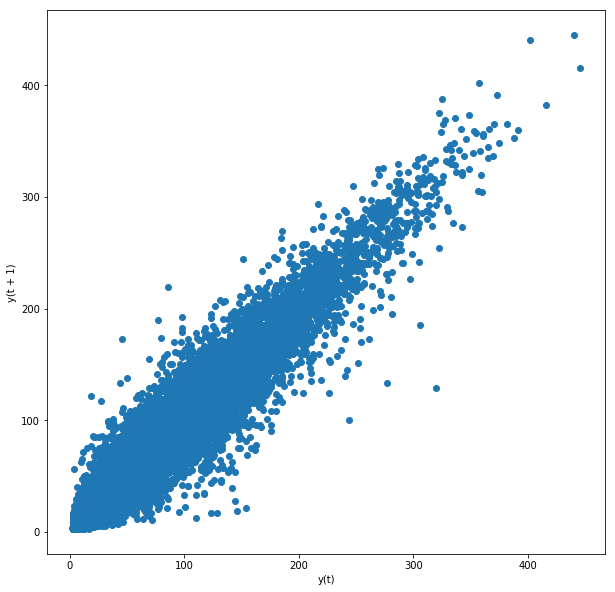

In [14]:
# Plot the time series against its lag1
plt.figure(figsize=(10, 10))
lag_plot(df)
plt.show();

In [15]:
# Calculate autocorrelation coefficient
df1 = pd.concat([df, df.shift(1)], axis=1)
df1.columns = ['t', 't-1']
df1.head()

,t,t-1
Datetime,,
2008-01-01 01:00:00,92.0,NaN
2008-01-01 02:00:00,81.0,92.0
2008-01-01 03:00:00,73.0,81.0
2008-01-01 04:00:00,60.5,73.0
2008-01-01 05:00:00,61.0,60.5


In [16]:
df1.corr(method='pearson')

,t,t-1
t,1.000000,0.972629
t-1,0.972629,1.000000


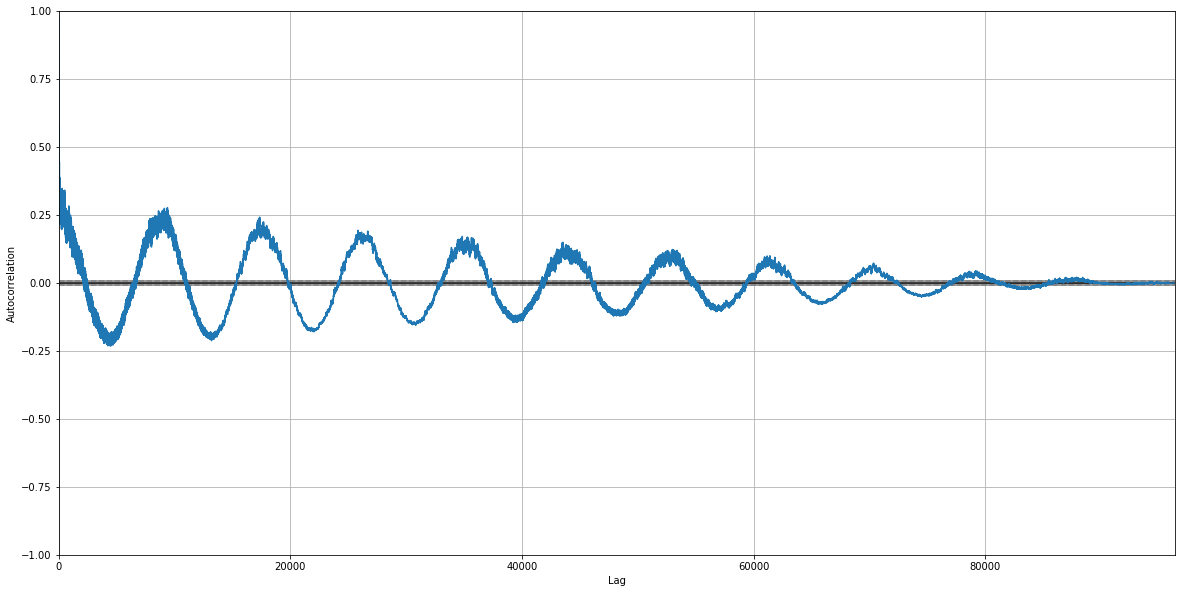

In [18]:
# Plot the autocorrelation plot of the dataset
plt.figure(figsize=(20, 10))
autocorrelation_plot(df)
plt.show();

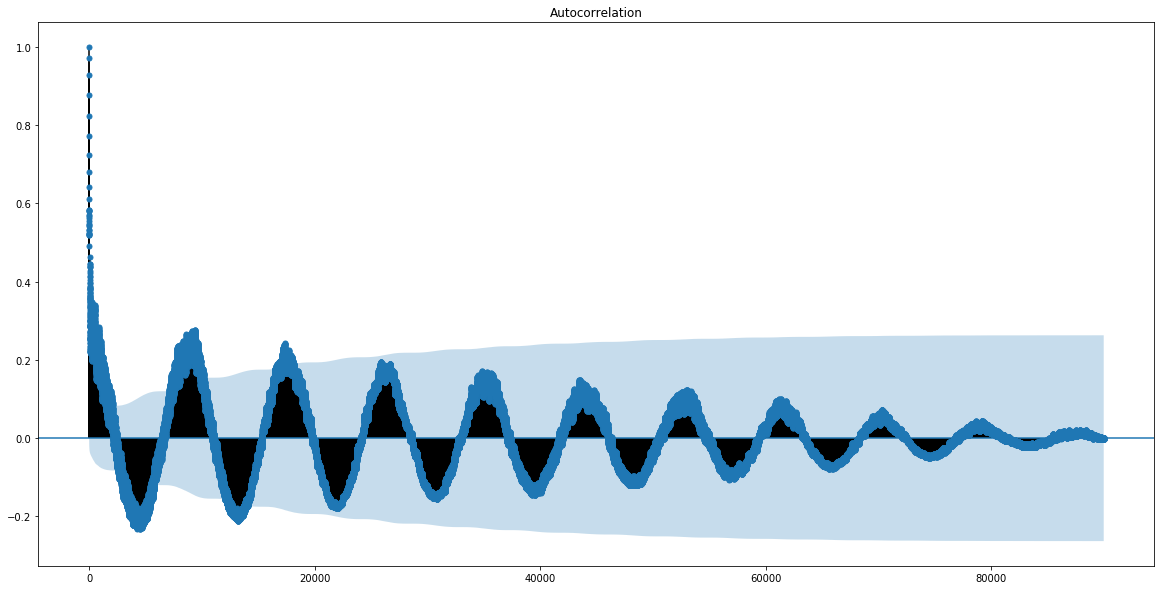

In [21]:
# Plot the AutoCorrelation Function, using candle sticks
fig, (ax) = plt.subplots(1, 1, figsize=(20, 10))
plot_acf(df, ax=ax, lags=90000)
plt.show();

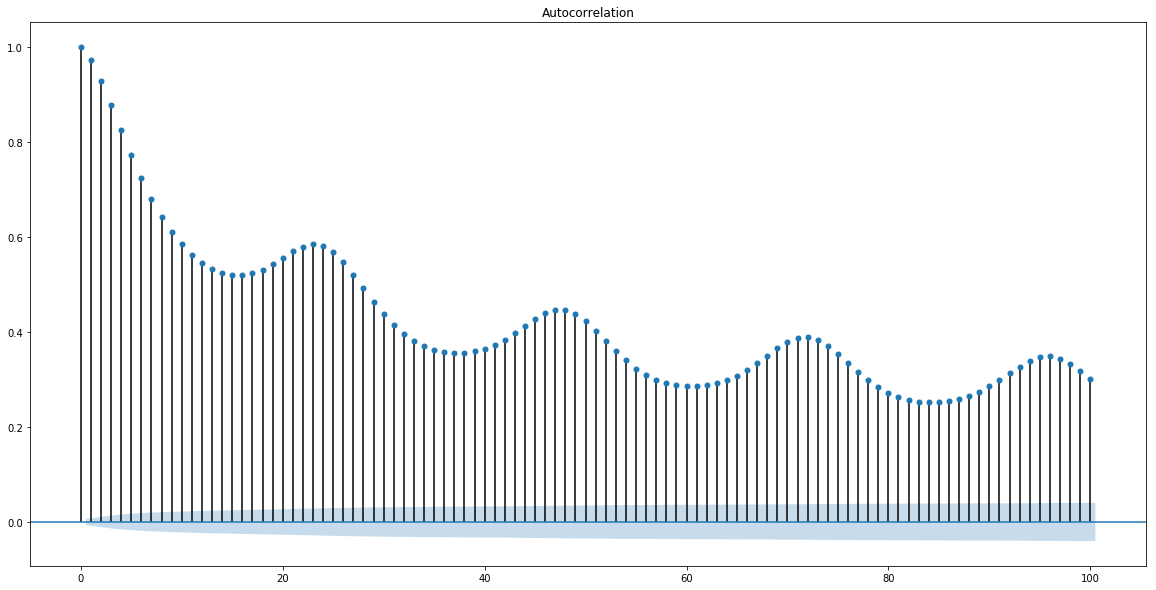

In [22]:
# Plot the AutoCorrelation Function, using candle sticks
fig, (ax) = plt.subplots(1, 1, figsize=(20, 10))
plot_acf(df, ax=ax, lags=100)
plt.show();

In [ ]:
# There is a function for that:

In [104]:
def get_df_for_lags_columns(data: pd.DataFrame, col_name: str, n_lags: int = 1) -> pd.DataFrame:
    
    # Builds n-lags data frame for a time series
    df = pd.DataFrame()
    
    # Create column t
    df['t'] = data[col_name].copy()
    
    # Create lag columns
    for i in range(1, n_lags+1):
        df['t-'+str(i)] = df['t'].shift(i)
        
    return df

In [47]:
# Calculate correlation coefficients for a number of lags
lags = 10

df1 = df.copy()
columns = ['t']

for i in range(1, (lags + 1)):
    df1 = pd.concat([df1, df.shift(i)], axis=1)
    columns.append(f't-{i}')
    #print(columns)
    #print(df1.head(1))
    

df1.columns = columns
df1.head(lags+1)

,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
Datetime,,,,,,,,,,,
2008-01-01 01:00:00,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-01 02:00:00,81.0,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-01 03:00:00,73.0,81.0,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-01 04:00:00,60.5,73.0,81.0,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-01 05:00:00,61.0,60.5,73.0,81.0,92.0,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-01 06:00:00,67.0,61.0,60.5,73.0,81.0,92.0,NaN,NaN,NaN,NaN,NaN
2008-01-01 07:00:00,69.5,67.0,61.0,60.5,73.0,81.0,92.0,NaN,NaN,NaN,NaN
2008-01-01 08:00:00,70.5,69.5,67.0,61.0,60.5,73.0,81.0,92.0,NaN,NaN,NaN
2008-01-01 09:00:00,62.5,70.5,69.5,67.0,61.0,60.5,73.0,81.0,92.0,NaN,NaN


In [53]:
corr = df1.corr(method='pearson')
corr

,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
t,1.000000,0.972629,0.928892,0.878064,0.824615,0.772482,0.723833,0.680735,0.642857,0.610752,0.584242
t-1,0.972629,1.000000,0.972629,0.928893,0.878064,0.824616,0.772482,0.723834,0.680736,0.642858,0.610753
t-2,0.928892,0.972629,1.000000,0.972629,0.928893,0.878065,0.824616,0.772483,0.723834,0.680737,0.642859
t-3,0.878064,0.928893,0.972629,1.000000,0.972629,0.928893,0.878065,0.824616,0.772483,0.723835,0.680738
t-4,0.824615,0.878064,0.928893,0.972629,1.000000,0.972629,0.928893,0.878065,0.824617,0.772484,0.723836
t-5,0.772482,0.824616,0.878065,0.928893,0.972629,1.000000,0.972629,0.928893,0.878065,0.824617,0.772484
t-6,0.723833,0.772482,0.824616,0.878065,0.928893,0.972629,1.000000,0.972629,0.928893,0.878065,0.824617
t-7,0.680735,0.723834,0.772483,0.824616,0.878065,0.928893,0.972629,1.000000,0.972629,0.928893,0.878065
t-8,0.642857,0.680736,0.723834,0.772483,0.824617,0.878065,0.928893,0.972629,1.000000,0.972629,0.928893
t-9,0.610752,0.642858,0.680737,0.723835,0.772484,0.824617,0.878065,0.928893,0.972629,1.000000,0.972629


In [54]:
corr[0:1]

,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
t,1.0,0.972629,0.928892,0.878064,0.824615,0.772482,0.723833,0.680735,0.642857,0.610752,0.584242


What we can see here is yearly and daily sesonal cycles and the most influencing (autocorrelated) hourly lags being closer to the observation point at lag 0. The first 6 lagged values are highly correlated to the times series (correlation coefficient higher than 0.7), and this correlation is statistifically significant. After lag 6, we observe steady decline of correlation.

In [25]:
adfuller_test(df)

Test statistic: -18.348339980165512
P-value: 2.2390596215367323e-30 -> 0.0000000000000000
Critical values: {'1%': -3.4304178932130585, '5%': -2.8615700077238575, '10%': -2.5667859720635713}
The time series does not have a unit root, so it is stationary (reject H0)


A time series can be made stationary by removing/reducing trend and seasonality

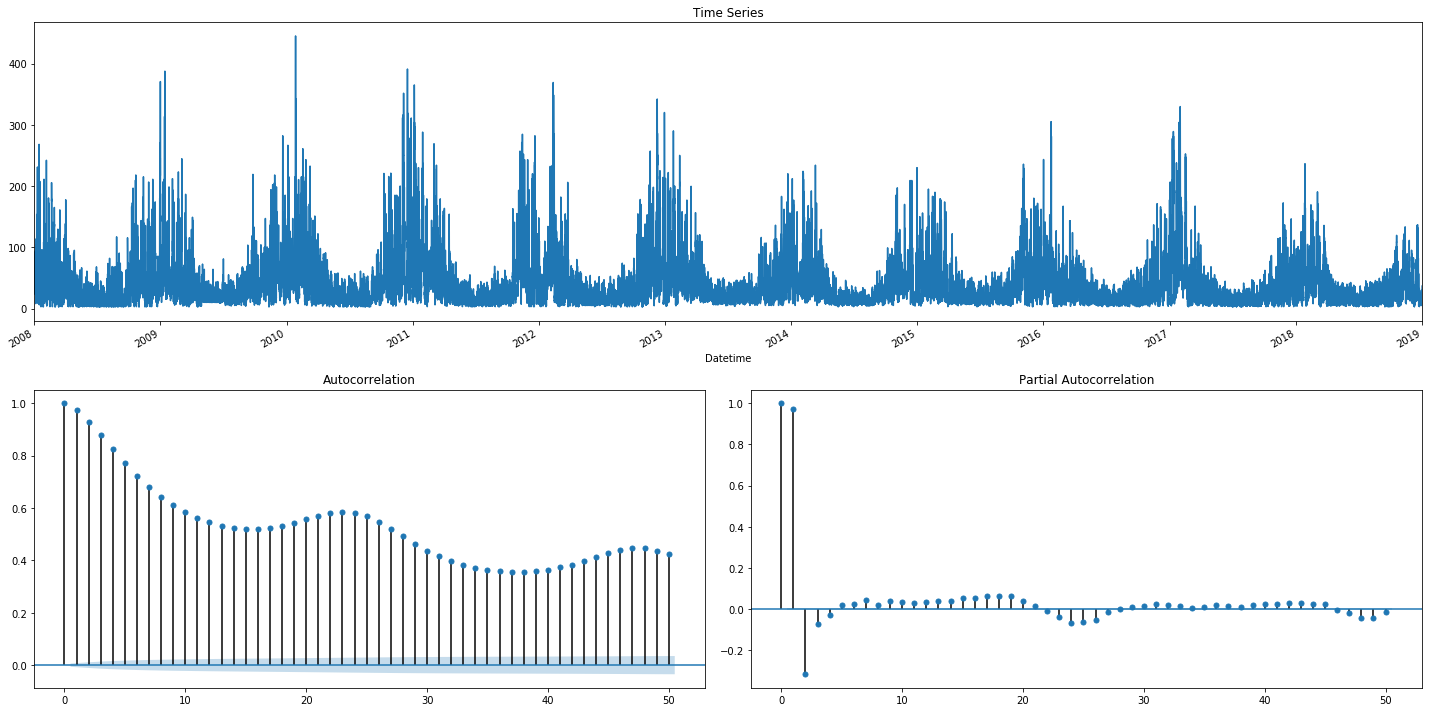

In [59]:
plot_ts_corr(df['pm25'])

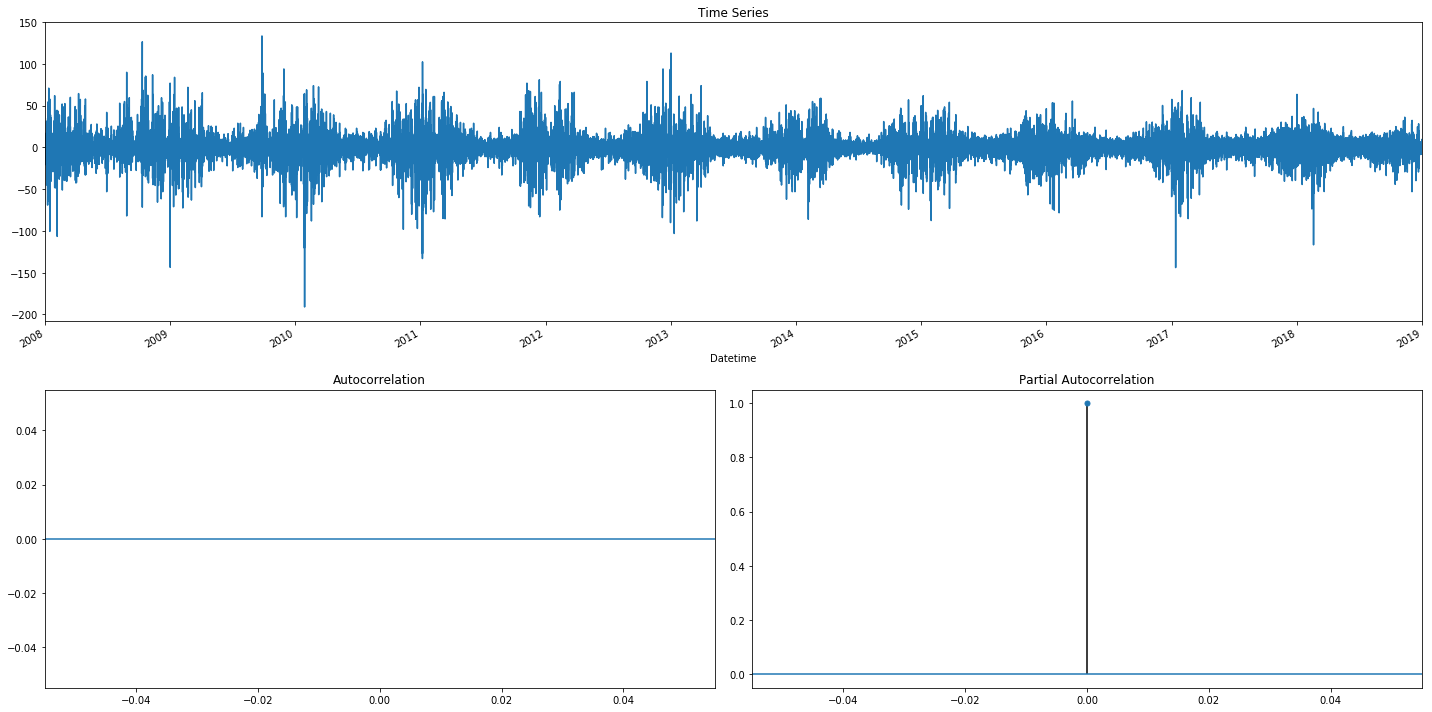

In [60]:
df1 = df.diff()
plot_ts_corr(df1['pm25'])

---
<a id='model_h'></a>

## Modelling

In statistical time series models, fitting the model means estimating its paraneters. In case of AR model, the only parameter to estimate is number of autocorrelated lags

In [65]:
from statsmodels.tsa.ar_model import AR

In [80]:
#create train/test datasets
X = df1.dropna()
offset = len(X)-(365*24)
train_data = X[1:len(X)-offset]
test_data = X[len(X)-offset:]

In [81]:
#train the autoregression model
model = AR(train_data)
model_fitted = model.fit()

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [82]:
print('The lag value chose is: %s' % model_fitted.k_ar)

The lag value chose is: 37


In [83]:
print('The coefficients of the model are:\n %s' % model_fitted.params)

The coefficients of the model are:
 const       0.033880
L1.pm25     0.191237
L2.pm25    -0.001695
L3.pm25    -0.034849
L4.pm25    -0.064674
L5.pm25    -0.045345
L6.pm25    -0.076473
L7.pm25    -0.055982
L8.pm25    -0.056154
L9.pm25    -0.050269
L10.pm25   -0.055450
L11.pm25   -0.041073
L12.pm25   -0.047666
L13.pm25   -0.059239
L14.pm25   -0.039135
L15.pm25   -0.053236
L16.pm25   -0.052043
L17.pm25   -0.058007
L18.pm25   -0.075033
L19.pm25   -0.039726
L20.pm25   -0.040127
L21.pm25   -0.040602
L22.pm25   -0.004065
L23.pm25    0.041850
L24.pm25    0.046102
L25.pm25    0.044811
L26.pm25   -0.017577
L27.pm25    0.002322
L28.pm25   -0.028402
L29.pm25   -0.026295
L30.pm25   -0.039506
L31.pm25   -0.012832
L32.pm25   -0.029638
L33.pm25   -0.019673
L34.pm25   -0.009403
L35.pm25   -0.022874
L36.pm25   -0.008399
L37.pm25   -0.030191
dtype: float64


In [84]:
# make predictions 
predictions = model_fitted.predict(
    start=len(train_data), 
    end=len(train_data) + len(test_data)-1, 
    dynamic=False)

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [85]:
# create a comparison dataframe
compare_df = pd.concat(
    [df1.tail(offset),
    predictions], axis=1).rename(
    columns={'stationary': 'actual', 0:'predicted'})

In [86]:
compare_df.tail(offset)

,pm25,predicted
2008-12-31 08:00:00,9.0000,NaN
2008-12-31 09:00:00,5.0000,NaN
2008-12-31 10:00:00,21.0000,NaN
2008-12-31 11:00:00,33.0000,NaN
2008-12-31 12:00:00,3.5000,NaN
...,...,...
2018-12-31 20:00:00,4.3808,NaN
2018-12-31 21:00:00,8.9318,NaN
2018-12-31 22:00:00,-1.5507,NaN
2018-12-31 23:00:00,2.1227,NaN


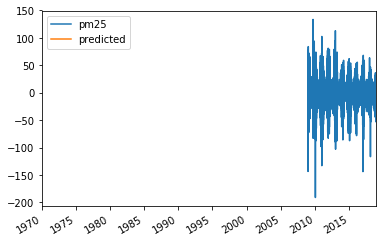

In [87]:
#plot the two values
compare_df.plot()

That’s really not a bad model at it shows trend and movements (high/lows, etc) well but doesn’t quite get the extreme values. 

In [89]:
from sklearn.metrics import r2_score

r2 = r2_score(df1.tail(offset), predictions)
r2

0.0006636594778069993

In [14]:
%%time
# Find best parameters (grid-search)
best_results = get_best_arima_params_for_time_series(data=df, 
                                                     seasonal=False, 
                                                     max_param_range_p=5, 
                                                     max_param_range_d=0, 
                                                     max_param_range_q=0) # AR model

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMAX(0, 0, 0) - AIC:1041117.938840279


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMAX(1, 0, 0) - AIC:697125.2637565346


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMAX(2, 0, 0) - AIC:687505.4245801942


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMAX(3, 0, 0) - AIC:687180.9667342468


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMAX(4, 0, 0) - AIC:687168.3674624764


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMAX(5, 0, 0) - AIC:687066.8937108214
Best model is ARIMA(5, 0, 0) with AIC of 687066.8937108214
CPU times: user 20.8 s, sys: 2.4 s, total: 23.2 s
Wall time: 8.14 s


In [15]:
best_results

((5, 0, 0), 687066.8937108214)

In [ ]:
SARIMAX(5, 0, 0) - AIC:687066.8937108214
Best model is ARIMA(5, 0, 0) with AIC of 687066.8937108214
CPU times: user 20.8 s, sys: 2.4 s, total: 23.2 s
Wall time: 8.14 s

In [16]:
# Estimating model

# Fit an AR(5) model
model = ARMA(df, order=(5,0))
result = model.fit()  # use fit() to estimate model

# Estimated parameters
print(result.summary())

# True parameters
print(f'True parameters:\n{result.params}')

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                   pm25   No. Observations:                96388
Model:                     ARMA(5, 0)   Log Likelihood             -342836.969
Method:                       css-mle   S.D. of innovations              8.482
Date:                Sat, 09 May 2020   AIC                         685687.938
Time:                        20:08:05   BIC                         685754.271
Sample:                             0   HQIC                        685708.102
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         37.2056      0.701     53.065      0.000      35.831      38.580
ar.L1.pm25     1.2567      0.003    390.241      0.000       1.250       1.263
ar.L2.pm25    -0.2306      0.005    -44.593      0.0

**Estimated parameters are close to true parameters. All AR coefficients are statistically significant.**

In [17]:
df.tail(24)

,pm25
Datetime,
2018-12-31 01:00:00,7.23137
2018-12-31 02:00:00,6.82297
2018-12-31 03:00:00,6.34370
2018-12-31 04:00:00,6.05348
2018-12-31 05:00:00,5.36824
2018-12-31 06:00:00,5.25741
2018-12-31 07:00:00,5.23353
2018-12-31 08:00:00,4.78421
2018-12-31 09:00:00,5.68586


In [18]:
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARMAResults.predict.html#statsmodels.tsa.arima_model.ARMAResults.predict
# dynamic = use in-sample predictions
pred = result.predict(start='2018-12-31 01:00:00', end='2019-01-01 00:00:00', dynamic=False)
pred

Datetime
2018-12-31 01:00:00    10.924869
2018-12-31 02:00:00     7.624695
2018-12-31 03:00:00     7.654481
2018-12-31 04:00:00     7.311964
2018-12-31 05:00:00     7.183544
2018-12-31 06:00:00     6.379209
2018-12-31 07:00:00     6.424092
2018-12-31 08:00:00     6.448336
2018-12-31 09:00:00     5.921731
2018-12-31 10:00:00     7.152400
2018-12-31 11:00:00     8.643617
2018-12-31 12:00:00     8.223492
2018-12-31 13:00:00    10.749466
2018-12-31 14:00:00     7.688368
2018-12-31 15:00:00    14.253724
2018-12-31 16:00:00    10.593249
2018-12-31 17:00:00    10.774379
2018-12-31 18:00:00    22.807100
2018-12-31 19:00:00    20.120688
2018-12-31 20:00:00    20.417825
2018-12-31 21:00:00    25.356407
2018-12-31 22:00:00    35.758227
2018-12-31 23:00:00    31.573343
2019-01-01 00:00:00    34.089371
dtype: float64

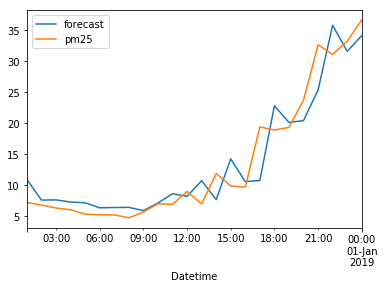

In [19]:
# Forecasting (in sample)
# Start the forecast 24 data points before the end of the point series

result.plot_predict(start='2018-12-31 01:00:00', end='2019-01-01 00:00:00', dynamic=False)
plt.show();

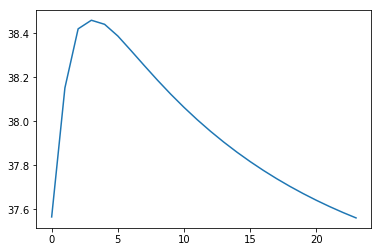

In [20]:
# Forecasting (out of sample)
forecast = result.forecast(24)
plt.plot(forecast[0])
#plt.ylim(0, 40)
plt.show();

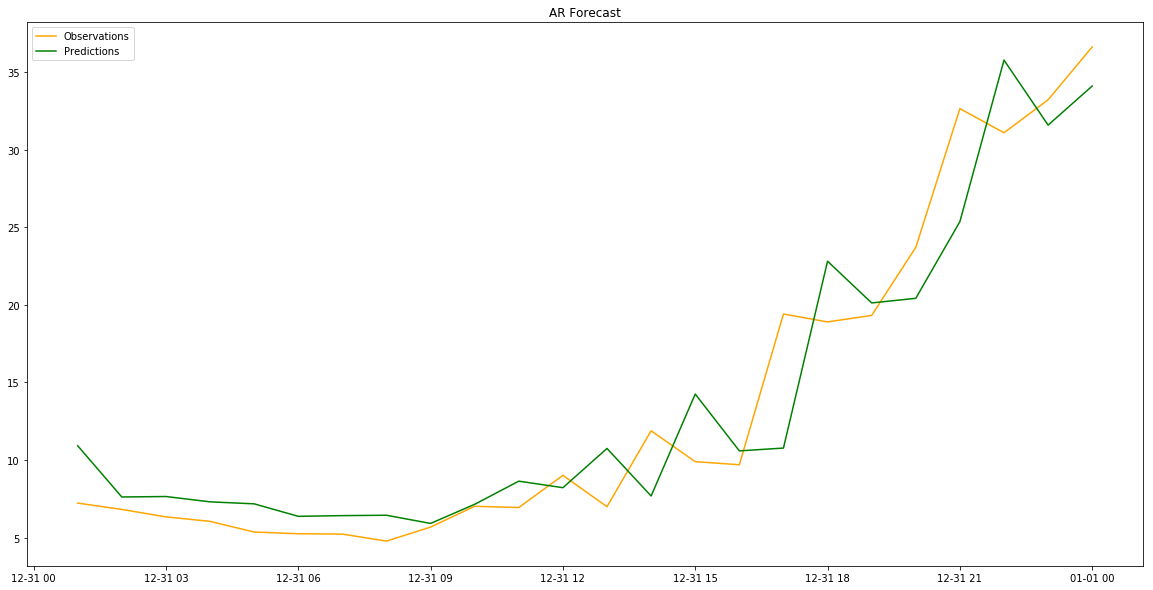

In [21]:
observed = df.iloc[-24:, 0]
predicted = pred

plot_observed_vs_predicted(observed=observed, 
                           predicted=predicted, 
                           num_points=125,
                           title="AR Forecast",
                           label_observed='Observations', 
                           label_predicted='Predictions')

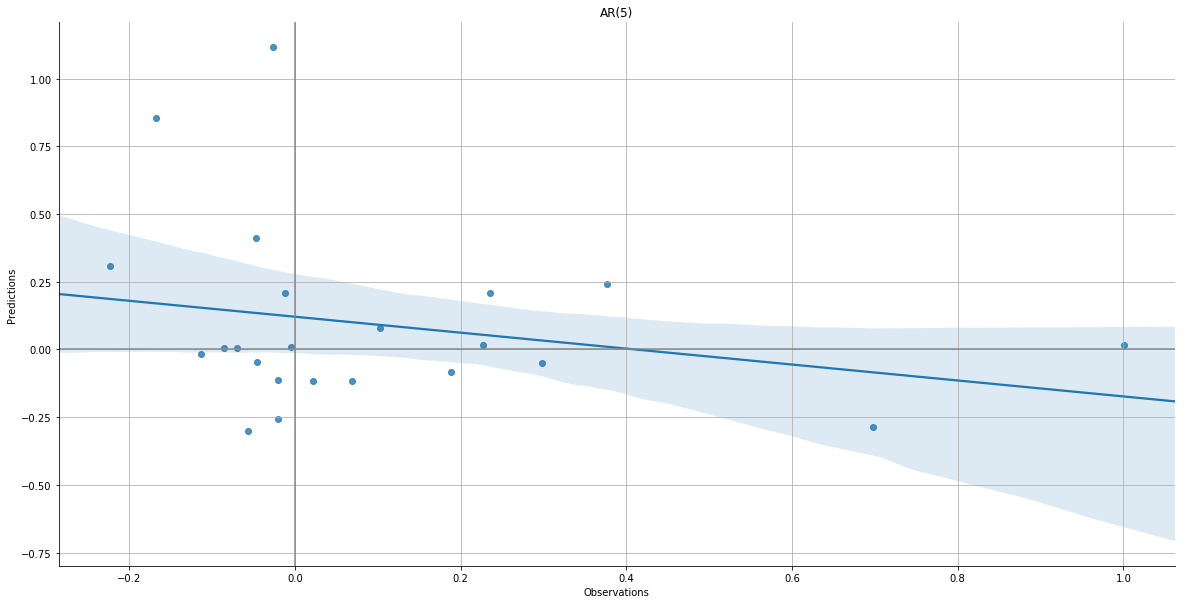

In [22]:
plot_observations_to_predictions_relationship(observed=observed, 
                                         predicted=predicted, 
                                         title="AR(5)",
                                         label_observed='Observations',
                                         label_predicted='Predictions')

In [23]:
rmse, r = get_model_power(df.iloc[-24:, 0], pred)
print(f'Naive forecast RMSE: {rmse:.4f}')
print(f'Naive forecast correlation coefficient of the observed-to-predicted values percent change: {r:.4f}')

Naive forecast RMSE: 3.3316
Naive forecast correlation coefficient of the observed-to-predicted values percent change: -0.2470


---
<a id='data_d'></a>

## Load daily data

In [24]:
data_file = data_path + 'dfpm25_2008-2018_daily.hdf'

df = pd.read_hdf(path_or_buf=data_file, key="df")
print(f'Dataframe size: {df.shape}')
df.head()

Dataframe size: (4019, 1)


,pm25
Datetime,
2008-01-01,53.586957
2008-01-02,30.958333
2008-01-03,46.104167
2008-01-04,42.979167
2008-01-05,57.312500


---
<a id='diag_d'></a>

## Diagnostics

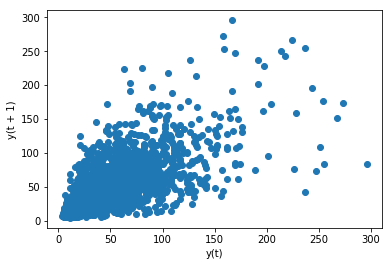

In [25]:
# Plot the time series against its lag
lag_plot(df)
plt.show();

In [26]:
# Calculate autocorrelation coefficient
#values = pd.DataFrame(vacation.values)
df1 = pd.concat([df, df.shift(1)], axis=1)
df1.columns = ['t', 't-1']
#df1.head()
df1.corr(method='pearson')

,t,t-1
t,1.000000,0.740933
t-1,0.740933,1.000000


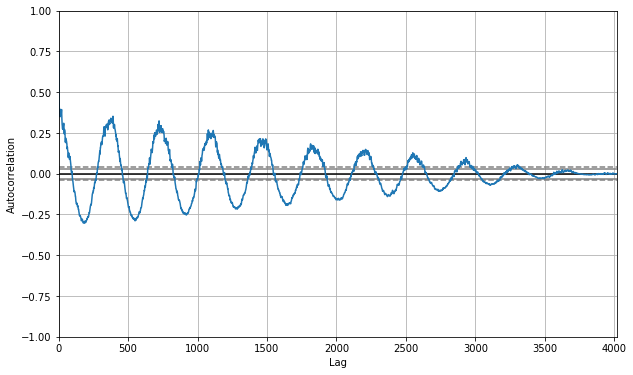

In [27]:
# Plot the autocorrelation plot of the dataset
plt.figure(figsize=(10, 6))
autocorrelation_plot(df)
plt.show();

<Figure size 864x432 with 0 Axes>

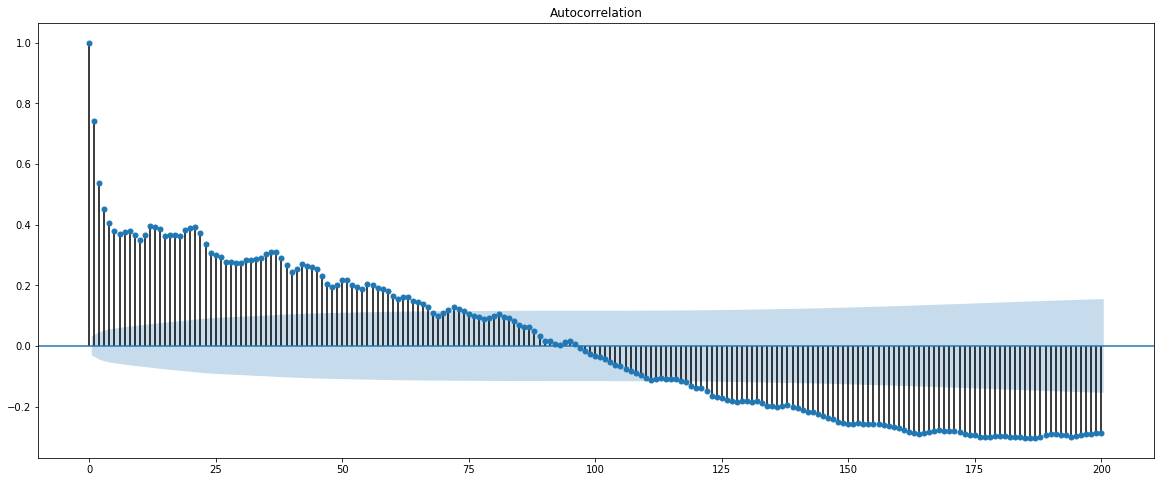

In [28]:
# Plot the AutoCorrelation Function, using candle sticks
plt.figure(figsize=(12, 6))
fig, (ax) = plt.subplots(1, 1, figsize=(20, 8))
plot_acf(df, ax=ax, lags=200)
plt.show();

---
<a id='model_d'></a>

## Modelling

In [29]:
%%time
# Find best parameters (grid-search)
best_results = get_best_arima_params_for_time_series(data=df, 
                                                     seasonal=False, 
                                                     max_param_range_p=5, 
                                                     max_param_range_d=0, 
                                                     max_param_range_q=0) # AR model

SARIMAX(0, 0, 0) - AIC:42732.42857170857
SARIMAX(1, 0, 0) - AIC:36470.13152150181
SARIMAX(2, 0, 0) - AIC:36460.28521861734
SARIMAX(3, 0, 0) - AIC:36287.30550351582
SARIMAX(4, 0, 0) - AIC:36236.94719038827
SARIMAX(5, 0, 0) - AIC:36186.50556147955
Best model is ARIMA(5, 0, 0) with AIC of 36186.50556147955
CPU times: user 2.57 s, sys: 383 ms, total: 2.95 s
Wall time: 662 ms


In [30]:
best_results

((5, 0, 0), 36186.50556147955)

In [31]:
# Estimating model

# Fit an AR(5) model
model = ARMA(df, order=(5,0))
result = model.fit()  # use fit() to estimate model

# Estimated parameters
print(result.summary())

# True parameters
print(f'True parameters:{result.params}')

                              ARMA Model Results                              
Dep. Variable:                   pm25   No. Observations:                 4019
Model:                     ARMA(5, 0)   Log Likelihood              -18008.664
Method:                       css-mle   S.D. of innovations             21.367
Date:                Sat, 09 May 2020   AIC                          36031.328
Time:                        20:08:10   BIC                          36075.419
Sample:                    01-01-2008   HQIC                         36046.953
                         - 01-01-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         37.2064      1.692     21.986      0.000      33.890      40.523
ar.L1.pm25     0.7504      0.016     47.691      0.000       0.720       0.781
ar.L2.pm25    -0.1315      0.020     -6.680      0.0

**Estimated parameters are close to true parameters. All AR coefficients but L4 are statistically significant.**

In [32]:
df.tail(7)

,pm25
Datetime,
2018-12-26,17.102352
2018-12-27,15.274438
2018-12-28,18.614863
2018-12-29,16.241051
2018-12-30,15.514396
2018-12-31,12.595460
2019-01-01,36.607400


In [33]:
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARMAResults.predict.html#statsmodels.tsa.arima_model.ARMAResults.predict
# dynamic = use in-sample predictions
pred = result.predict(start='2018-12-26', end='2019-01-01', dynamic=False)
pred

Datetime
2018-12-26    23.180264
2018-12-27    19.643370
2018-12-28    19.514119
2018-12-29    21.816305
2018-12-30    19.977312
2018-12-31    20.159791
2019-01-01    17.722444
Freq: D, dtype: float64

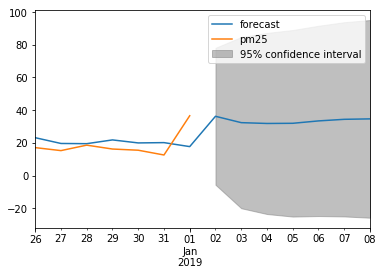

In [34]:
# Forecasting (in-sample)
# Start the forecast 7 data points before the end of the point series

result.plot_predict(start='2018-12-26', end='2019-01-08', dynamic=False)
plt.show();

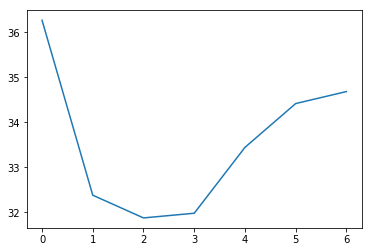

In [35]:
# Forecasting (out of sample)
forecast = result.forecast(7)
plt.plot(forecast[0])
#plt.ylim(0, 40)
plt.show();

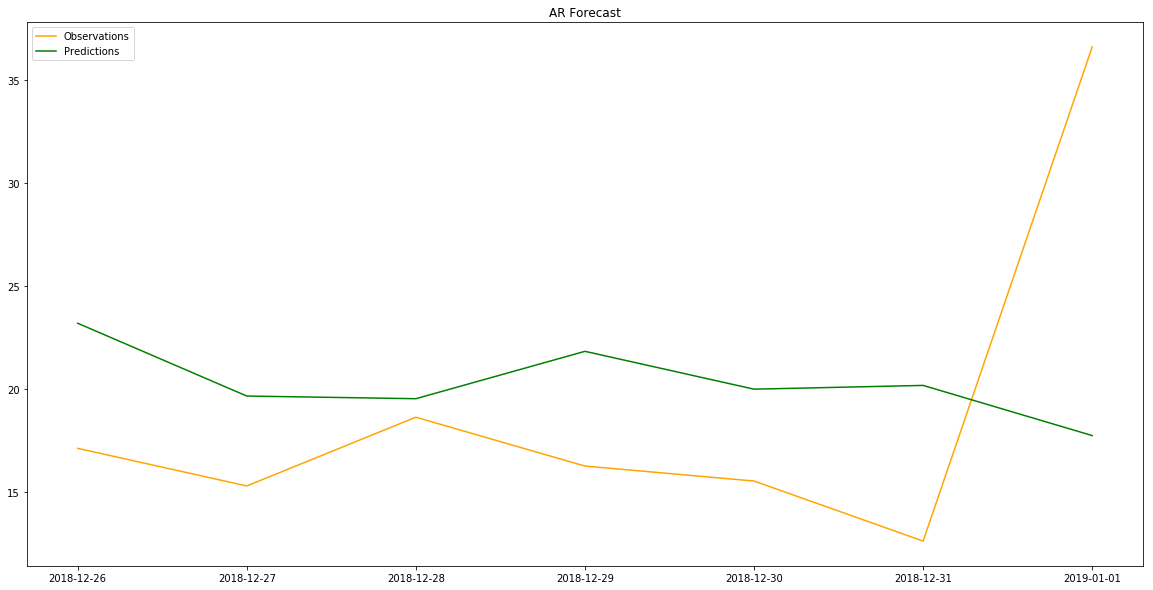

In [36]:
observed = df.iloc[-7:, 0]
predicted = pred

plot_observed_vs_predicted(observed=observed, 
                           predicted=predicted, 
                           num_points=125,
                           title="AR Forecast",
                           label_observed='Observations', 
                           label_predicted='Predictions')

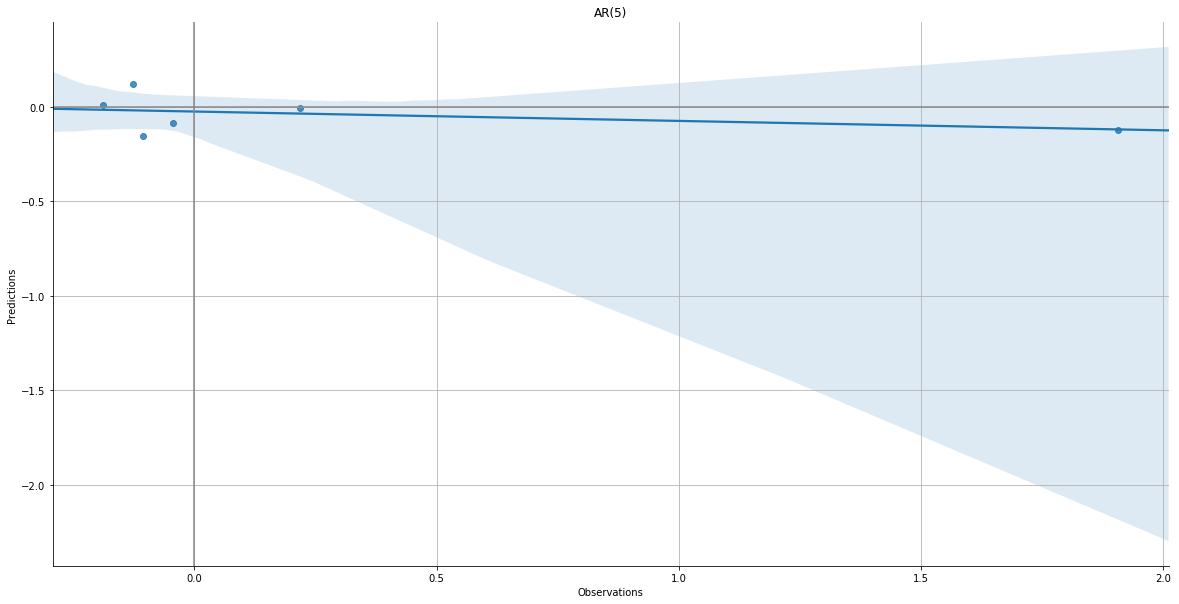

In [37]:
plot_observations_to_predictions_relationship(observed=observed, 
                                         predicted=predicted, 
                                         title="AR(5)",
                                         label_observed='Observations',
                                         label_predicted='Predictions')

In [38]:
rmse, r = get_model_power(df.iloc[-7:, 0], pred)
print(f'Naive forecast RMSE: {rmse:.4f}')
print(f'Naive forecast correlation coefficient of the observed-to-predicted values percent change: {r:.4f}')

Naive forecast RMSE: 8.6330
Naive forecast correlation coefficient of the observed-to-predicted values percent change: -0.4034
